<h1 style="text-align:center; color:#8738d6;">ROSES Unit 8 — PyGMT (Lab notebook)</h1>
<br>
<br>
<div style="text-align:center; font-size:16px">
    <b><a href="https://liam.earth/">Liam Toney</a></b><br>
    <br>
    Geophysical Institute,<br>
    University of Alaska Fairbanks<br>
    <br>
    11 August 2020
</div>

---
## Lab Activity 1 — Station map from ObsPy Stream

This activity will showcase a real-word use of PyGMT: Creating station maps. We'll try out and modify a handy, generalizable station map creation function, `plot_stations()`, that can plot the stations contained in an ObsPy Stream. I've provided most, but not all, of the code for this function.

**Note:** Since the focus here is on PyGMT and not ObsPy, I've provided a function which attaches coordinates to ObsPy streams using ObsPy's [`Client.get_stations()`](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_stations.html) method. It's defined below; don't worry too much about the inner workings (unless you're curious, of course).

In [1]:
from obspy.clients.fdsn import Client
import numpy as np

client = Client('IRIS')

def attach_iris_coordinates(st):
    """Returns a copy of the input Stream with coordinates from IRIS FDSN attached."""
    inv = client.get_stations(
        starttime=np.max([tr.stats.starttime for tr in st]),
        endtime=np.min([tr.stats.endtime for tr in st]),
        network=','.join(np.unique([tr.stats.network for tr in st])),
        station=','.join(np.unique([tr.stats.station for tr in st])),
        location=','.join(np.unique([tr.stats.location for tr in st])),
        channel=','.join(np.unique([tr.stats.channel for tr in st])),
        level='channel',
    )
    st_out = st.copy()
    for tr in st_out:
        coords = inv.get_coordinates(tr.id)
        tr.stats.longitude = coords['longitude']
        tr.stats.latitude = coords['latitude']
    return st_out

Now, for the actual station map function. This function takes two arguments: `st` and `label`. The latter argument controls labeling of stations with their network and station codes, and **is not implemented** — so setting `label=True` does nothing! Go ahead and run the below cell to define the function, and then try the following:

1. Experiment with providing different Streams (i.e., of your favorite station(s) or network) to this function, and see how it responds (see example usage below) — try to understand how the `region` and `projection` are chosen, and how we avoid plotting multiple Traces belonging to the same station, for e.g. three-component data.
<br><br>
2. Implement the station labeling functionality. This can be accomplished by adding a single line where I've placed a `TODO` below.

**Bonus:** Add an automatically-sized scalebar to the map. See the [documentation for `Figure.basemap()`](https://www.pygmt.org/latest/api/generated/pygmt.Figure.basemap.html#pygmt.Figure.basemap) to get started.

In [2]:
import pygmt

def plot_stations(st, label=False):
    """Plot the stations in an ObsPy Stream on a map.
    
    Args:
        st (ObsPy Stream): The input ObsPy Stream. Coordinates
            for the stations in the Stream are automagically
            grabbed from the IRIS FDSN.
        label (bool): If True, label markers with network and
            station information.
            
    Returns:
        PyGMT Figure: The completed figure, ready to be
            shown with e.g. fig.show().
    """
    
    # Gather coordinates for this Stream using the above helper function (makes a copy)
    st_plot = attach_iris_coordinates(st)
    
    # Get coordinates and labels for each stations
    lons = []
    lats = []
    names = []
    unique_stations = np.unique([tr.stats.station for tr in st_plot])
    for station in unique_stations:
        tr = st_plot.select(station=station)[0]  # Just taking the first Trace if multiple
        lons.append(tr.stats.longitude)
        lats.append(tr.stats.latitude)
        names.append(f'{tr.stats.network}.{tr.stats.station}')
        
    # Determine a nice, padded region
    region = [np.min(lons), np.max(lons), np.min(lats), np.max(lats)]
    x_pad = (region[1] - region[0]) * 0.1
    y_pad = (region[3] - region[2]) * 0.1
    region = [region[0] - x_pad, region[1] + x_pad, region[2] - y_pad, region[3] + y_pad]
    
    # Determine a nice stereographic projection
    lon_0 = np.mean(region[:2])
    lat_0 = np.mean(region[2:])
    if lat_0 > 0:
        ref_lat = 90
    else:
        ref_lat = -90
    projection = f'S{lon_0}/{ref_lat}/6i'
    
    # Create figure
    fig = pygmt.Figure()
    fig.coast(
        region=region,
        projection=projection,
        shorelines=True,
        water='lightblue',
        land='lightgrey',
        N=[1, 2],
        frame='a',
    )
    fig.plot(lons, lats, style='i0.2i', color='red', pen=True)
    if label:
        pass
        """
        TODO: Add a line here to enable station labeling. Hint: Look for a function
              that can plot text within the PyGMT API Reference webpage:
              https://www.pygmt.org/latest/api/index.html
        """

    return fig

Example usage (try grabbing data for different stations/networks to see what happens).

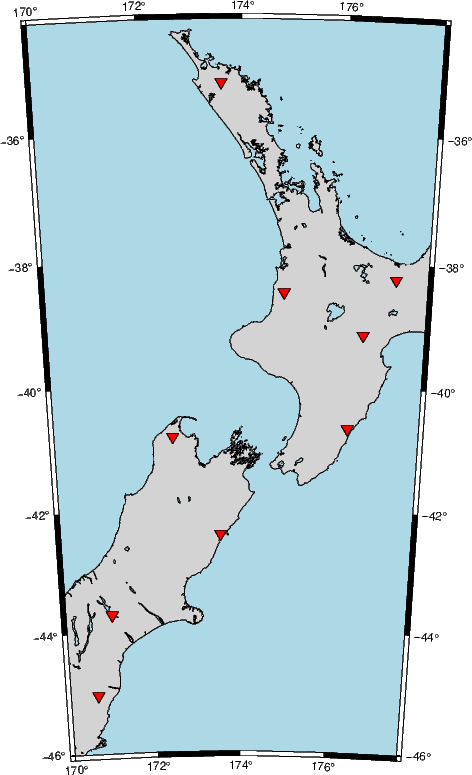

In [3]:
from obspy import UTCDateTime

# Grab a Stream of stations from the NZ National Seismographic Network
# (I'm keeping the data duration short here for demonstration's sake)
starttime = UTCDateTime(2020, 7, 1)
st = client.get_waveforms(
    network='NZ',
    station='*',
    location='*',
    channel='HHZ',
    starttime=starttime,
    endtime=starttime + 5,
)

# Plot stations
plot_stations(st, label=False)

---
## Lab Activity 2 — Plotting depth slices through a tomographic model

Contextualizing tomographic models on a map is another common mapping task for seismologists. In this activity, we'll plot depth slices of a (very unrealistic) tomographic model of Volcán Villarica in Chile, with some geographic context. The below cell creates a 3D [`xarray.DataArray`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html) with dimensions of latitude, longitude, and depth (km) and data values of shear-wave velocity (km/s).

In [4]:
import xarray as xr

VILLARICA_COORDS = (-71.93, -39.42)

INC = 0.005  # [deg.] Cell size for tomography model
EXTENT = 0.1  # [deg.] Extent (radius from volcano) of model
axis = np.arange(-EXTENT, EXTENT + INC, INC)
x = axis + VILLARICA_COORDS[0]
y = axis + VILLARICA_COORDS[1]
depth = [5, 10, 15]  # [km] Depths for model

VS_MIN = 1  # [km/s]
VS_RANGE = 3  # [km/s]

# Construct and tweak model velocities
model = VS_RANGE * np.random.random_sample(
    size=(x.size, y.size, len(depth))
) + VS_MIN  # [km/s]
for i in range(len(depth)):
    model[:,:,i] += i  # Make deeper layers faster
    
# Create xarray DataArray
model = xr.DataArray(model, coords=(y, x, depth), dims=('lat', 'lon', 'depth'))
print(model.coords)

Coordinates:
  * lat      (lat) float64 -39.52 -39.52 -39.51 -39.51 ... -39.33 -39.33 -39.32
  * lon      (lon) float64 -72.03 -72.03 -72.02 -72.02 ... -71.84 -71.84 -71.83
  * depth    (depth) int64 5 10 15


Now to plot — if you run the cell below, you'll see a pretty shaded-relief grayscale image of Villarica, but no tomographic slice. You'll need to add a line where I've marked `TODO` to plot a model depth slice. Once you have the model plotted, try changing the value of `DEPTH` below to see how velocity varies with depth.

**Bonus:** Can you figure out how to make the slice translucent? Hint: You'll need to look at the GMT docs for `grdimage` for this!

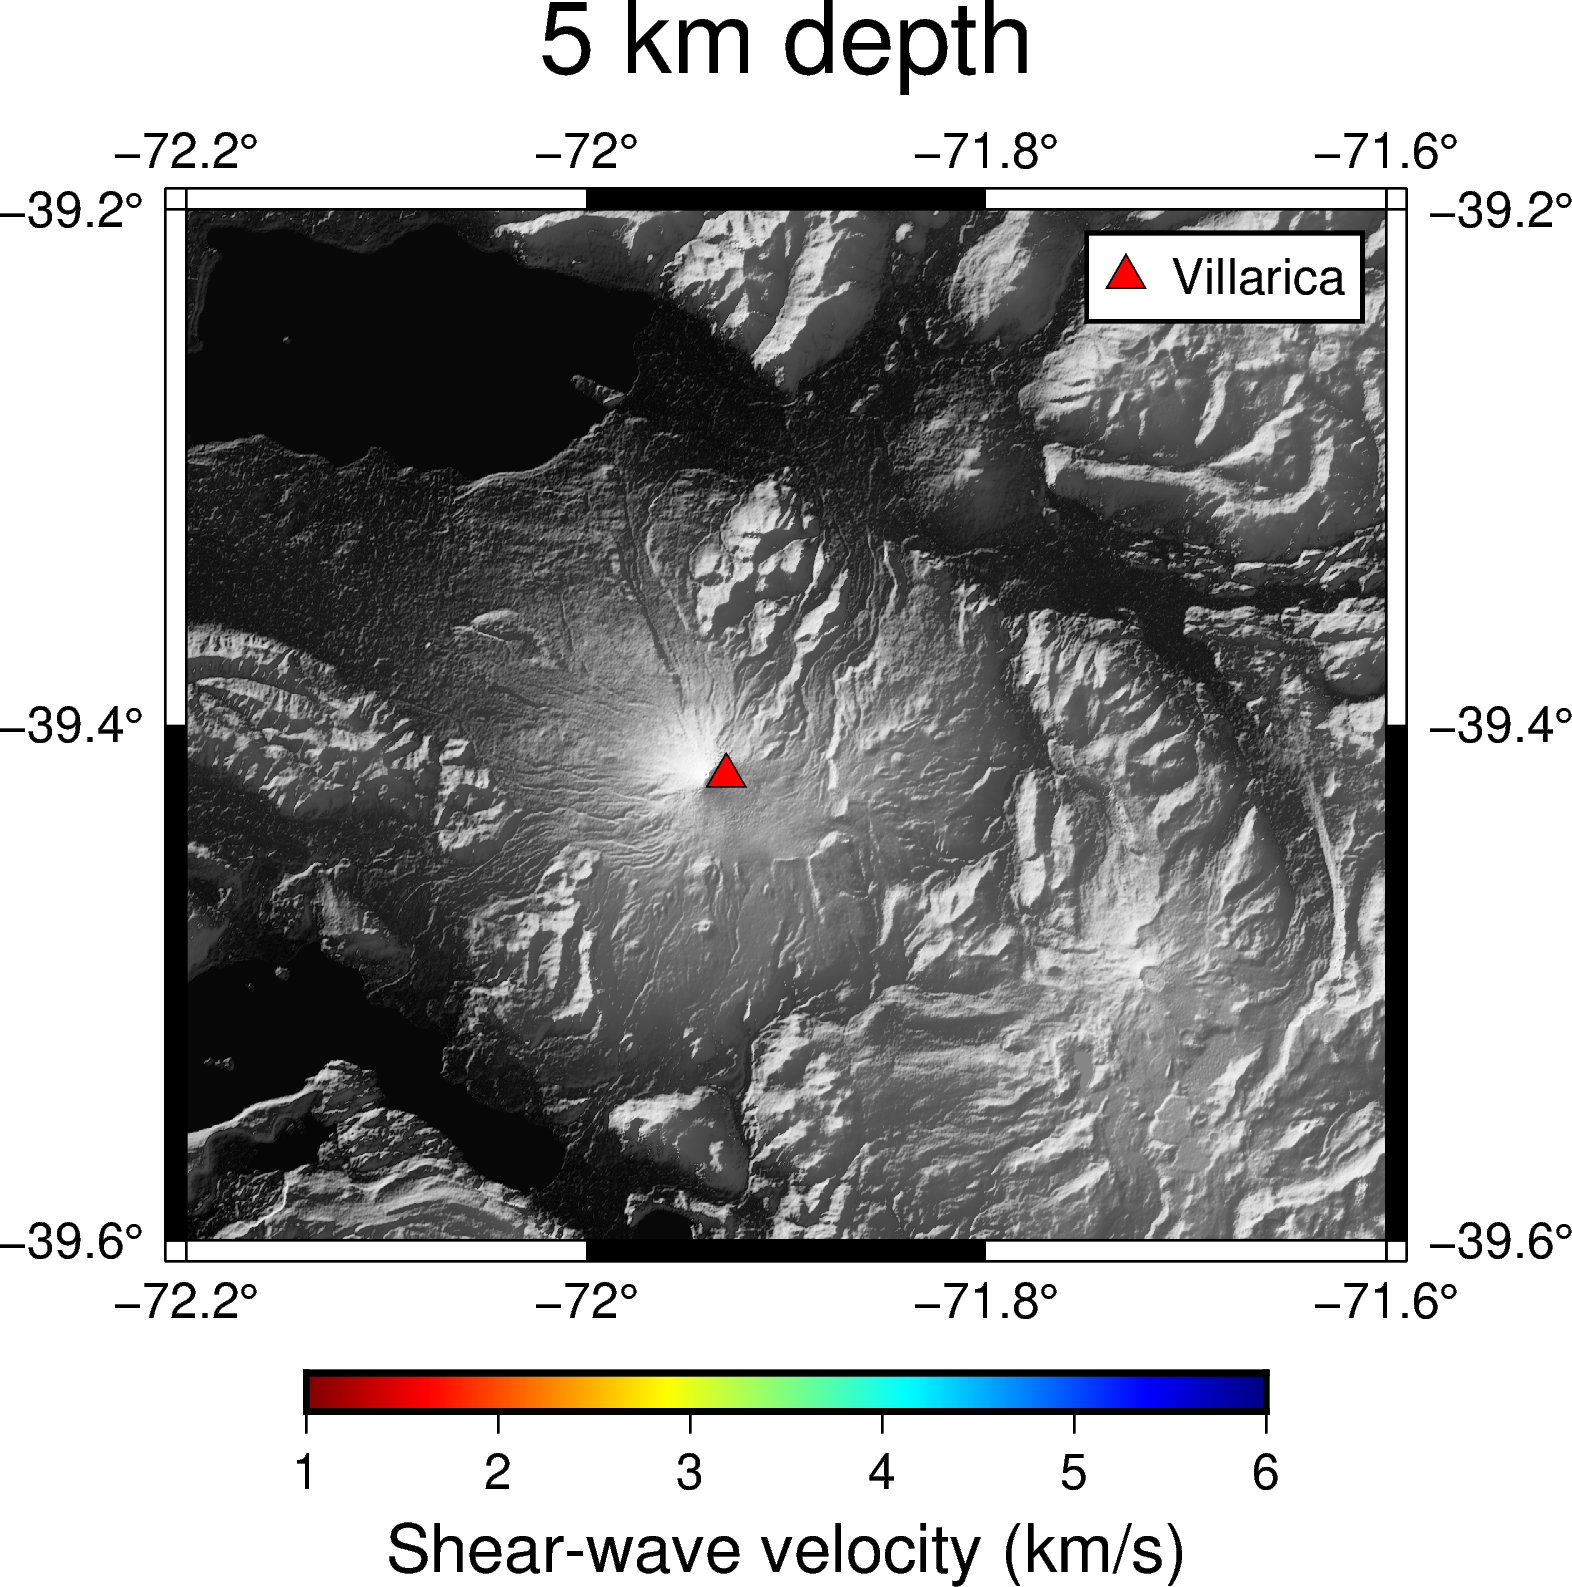

In [5]:
DEPTH = 5  # [km]

assert DEPTH in depth, f'DEPTH must be one of {depth} km!'

fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='D')  # Use decimal degrees
fig.grdimage(
    '@srtm_relief_01s',
    region=[-72.2, -71.6, -39.6, -39.2],
    projection='M4i',
    cmap='gray',
    frame=['a0.2', f'+t"{DEPTH} km depth"'],
    shading=True,
)
pygmt.makecpt(cmap='jet', reverse=True, series=[VS_MIN, int(np.ceil(model.max()))])
"""
TODO: Add a line here to plot a slice through the tomographic model
      corresponding to DEPTH. Hint: To select a depth slice from the
      "model" DataArray, use the following syntax: model.sel(depth=DEPTH).
      What PyGMT plotting method plots grids?
"""
fig.colorbar(frame='a1+l"Shear-wave velocity (km/s)"')
fig.plot(*VILLARICA_COORDS, style='t0.15i', color='red', pen=True, label='Villarica')
fig.legend()
fig.show()